In [7]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

In [2]:
df = pd.read_csv('../data/processed/train_processed.csv')

In [3]:
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,100003.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100004.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# SEPARATE FEATURES (X) AND TARGET (y)
X = df.drop('TARGET', axis=1)
y = df['TARGET']

In [5]:
# SPLIT TRAIN AND TEST
# We keep 20% of data aside to test if our model actually works
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Note: stratify=y ensures that both Train and Test have exactly 8% defaulters. Very important!

In [6]:
print(f"Training Data Shape: {X_train.shape}")
print(f"Test Data Shape: {X_test.shape}")

Training Data Shape: (246008, 249)
Test Data Shape: (61503, 249)


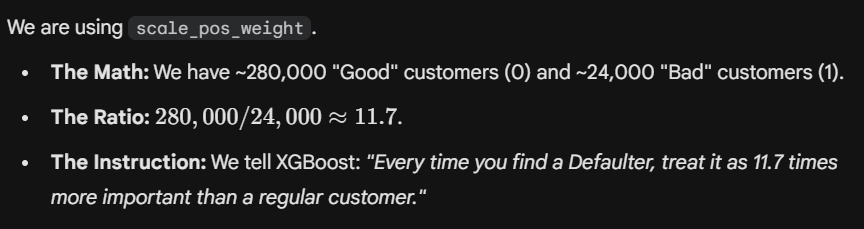

We are using scale_pos_weight.
The Math: We have ~280,000 "Good" customers (0) and ~24,000 "Bad" customers (1).
The Ratio: 280,000 / 24,000 = 11.7.
The Instruction: We tell XGBoost: "Every time you find a Defaulter, treat it as 11.7 times more important than a regular customer."

In [8]:
# CALCULATE IMBALANCE RATIO
# We need to tell XGBoost how much to "weight" the defaulters
ratio = float(np.sum(y == 0)) / np.sum(y == 1)
print(f"Imbalance Ratio (scale_pos_weight): {ratio:.2f}")

Imbalance Ratio (scale_pos_weight): 11.39


In [9]:
# INITIALIZE XGBOOST
# n_estimators=100: We will build 100 trees 
# max_depth=4: Each tree is only 4 levels deep (prevents memorizing data)
# learning_rate=0.1: We learn slowly to be more precise
clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=ratio,  # <--- The Imbalance Fixer
    random_state=42,
    n_jobs=-1  # Use all computer cores
)

In [10]:
# TRAIN (FIT)
print("Training started...")
clf.fit(X_train, y_train)
print("Training finished!")

Training started...
Training finished!


In [11]:
# PREDICT
# We predict "probabilities" (risk score), not just 0 or 1
y_pred_proba = clf.predict_proba(X_test)[:, 1]

In [12]:
# SCORE
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Model ROC-AUC Score: {auc:.4f}")

Model ROC-AUC Score: 0.7617


<Figure size 1000x800 with 0 Axes>

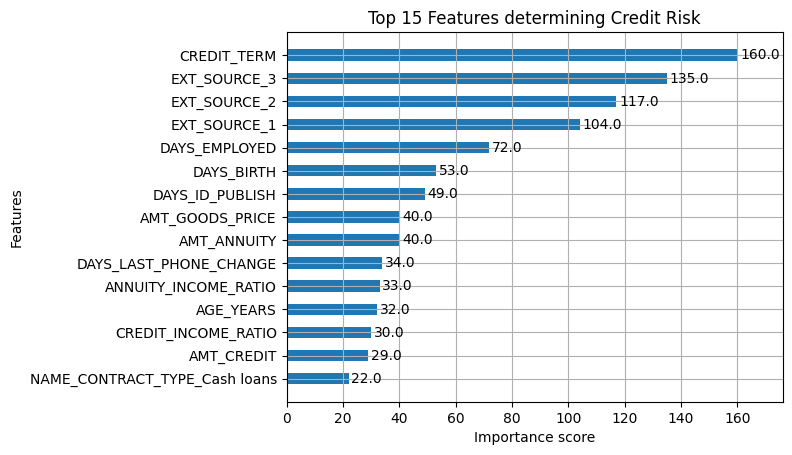

In [13]:
import matplotlib.pyplot as plt

# FEATURE IMPORTANCE
plt.figure(figsize=(10, 8))
xgb.plot_importance(clf, max_num_features=15, height=0.5, importance_type='weight')
plt.title("Top 15 Features determining Credit Risk")
plt.show()

First Word (True/False): Did the model get it Right?

Second Word (Positive/Negative): What did the model Predict?

<Figure size 800x600 with 0 Axes>

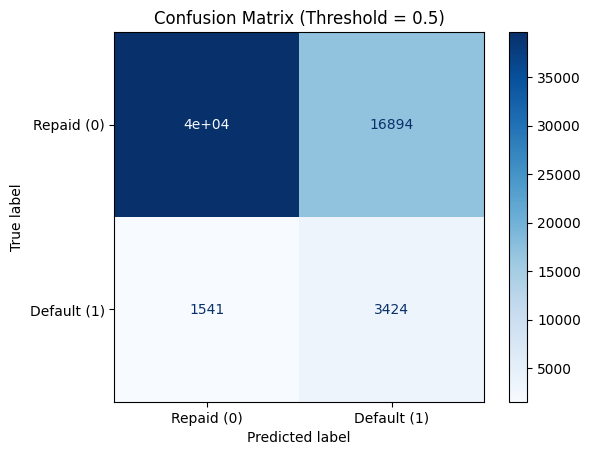

Confusion Matrix Text:
[[39644 16894]
 [ 1541  3424]]


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# CONFUSION MATRIX
# We need to turn probabilities (0.87, 0.23) into hard decisions (1 or 0)
# Let's assume if probability > 0.5, we reject the loan (Predict 1)
y_pred = (y_pred_proba > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Repaid (0)', 'Default (1)']).plot(cmap='Blues')
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.show()

print("Confusion Matrix Text:")
print(cm)

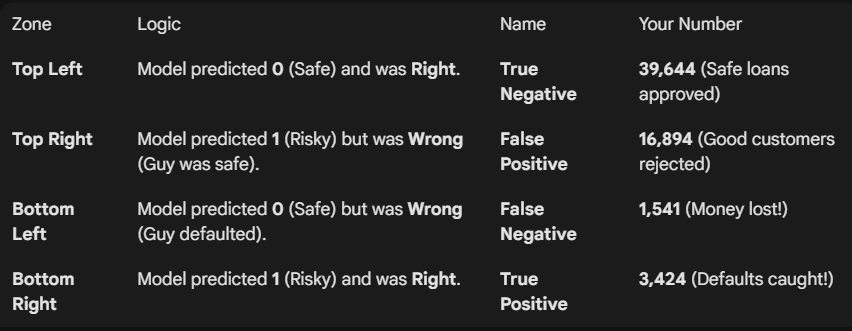

In [16]:
# SAVE MODEL
# We use joblib to save the trained model to a file
import joblib

joblib.dump(clf, '../models/xgboost_credit_risk_v1.joblib')
print("Model saved successfully to 'models/xgboost_credit_risk_v1.joblib'")

Model saved successfully to 'models/xgboost_credit_risk_v1.joblib'
